# Peaking test
This notebook uses the `EmissionsPeakTest` class, defined in the scripts section, to explore what level of reduction in Global Fossil CO2 emissions would be necessary to declare a peak with confidence.

Key steps are
- Load data into the EmissionsPeakTest class
- Characterise the noise (key choices here about whether to do the noise around a single trendline, or break the timeseries into a series of segments for analysis)
- Load test data for the future, and calculate the trendline for this data
- Do a bootstrap test to see how likely it is that outturn data with this trendline could actually be produced by a flat trend (H0 is that the trend=0), with just the noise contributing this variation


TODOs:
- Think about noise characterisation further: How best to characterise noise? Should we be breaking the timeseries into different sections? If so, how to endogenously determine this from the analysis?
- Find what level of reductions would be necessary to give a 66% and 90% likelihood of peaking

## Load packages

In [1]:
%load_ext autoreload
# %autoreload 2
# %reload_ext autoreload

In [1]:
import sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from peak_tester2 import CompleteEnhancedEmissionsPeakTest


In [5]:

# sns.set_palette('colorblind')

# # Enable grid and update its appearance
# plt.rcParams.update({'axes.grid': True})
# plt.rcParams.update({'grid.color': 'silver'})
# plt.rcParams.update({'grid.linestyle': '--'})

# # Set figure resolution
# plt.rcParams.update({'figure.dpi': 150})

# # Hide the top and right spines
# plt.rcParams.update({'axes.spines.top': False})
# plt.rcParams.update({'axes.spines.right': False})

# # Increase font sizes
# plt.rcParams.update({'font.size': 12})  # General font size
# plt.rcParams.update({'axes.titlesize': 14})  # Title font size
# plt.rcParams.update({'axes.labelsize': 12})  # Axis label font size

# Initial code

## Initialise peaker and characterise noise

In [13]:
peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', emissions_col = 'fossil_co2_emissions', year_range = range(1970,2024))

Loaded historical data: 1970-2023
Data points: 54


In [22]:
peak_tester.characterize_noise(method='segments',segment_length=5,distribution='auto',clip_distribution=(0.05,0.95), ignore_years=[2020])

Auto-selected normal distribution (AIC: 902.9 vs 904.9)
Fitted normal distribution:
  μ (mean) = 25.49
  σ (std)  = 340.52
Noise characterization complete:
  Method: segments
  Distribution: auto
  Noise std: 340.5 Mt
  Residuals: 64 points


## Test example trend and plot results

In [15]:
# Testing that with a flat trend, it gives ~50% chance that emissions have actually peaked
peak_tester.set_test_data([
        (2025, 37700),
        (2026, 37700), 
        (2027, 37700),
    ]).run_bootstrap_test(
        n_bootstrap=1000,
        alpha=0.1
    )

Test data set: 2025-2027
Test slope: 0.00 Mt/year (R² = 1.000)
Running bootstrap test with 1000 samples...
Bootstrap test complete:
  P-value (one-tail): 0.5030
  Significant (α=0.1): False


In [23]:
peak_tester.set_test_data([
        (2025, 37700),
        (2026, 37400), 
        (2027, 37100),
    ]).run_bootstrap_test(
        n_bootstrap=1000,
        alpha=0.1
    )

Test data set: 2025-2027
Test slope: -300.00 Mt/year (R² = 1.000)
Running bootstrap test with 1000 samples...
Bootstrap test complete:
  P-value (one-tail): 0.1180
  Significant (α=0.1): False


In [24]:
peak_tester.interpret_results(verbose=True)


INTERPRETATION OF RESULTS
Observed trend: declining at -300.0 Mt/year
Statistical evidence: insufficient evidence (p = 0.1180)
Conclusion: Declining trend present but not statistically significant


{'direction': 'decline',
 'trend_description': 'declining',
 'significance': 'insufficient evidence',
 'peak_conclusion': 'Declining trend present but not statistically significant',
 'confidence_in_peak': 'low',
 'p_value': '0.1180',
 'slope': '-300.0 Mt/year'}

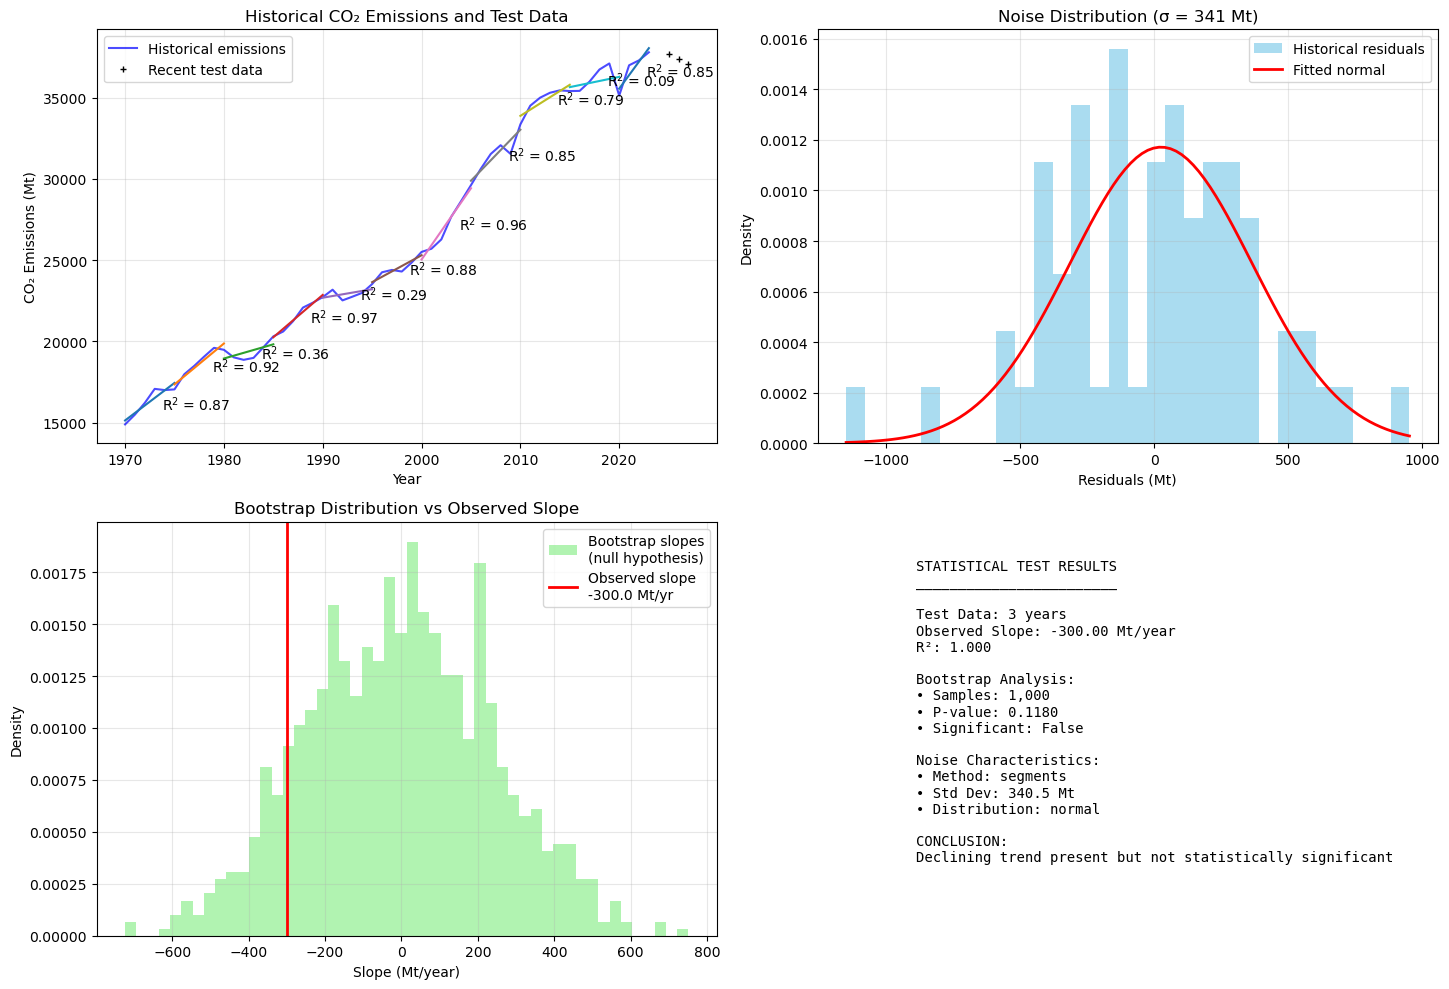

In [25]:
peak_tester.plot_analysis()

# New method 26 Aug

In [2]:
# Import data and exclude anomaly years

# Set random seed for reproducibility (CF: I'm not sure if this is needed)
# np.random.seed(42)

# Cell 2: Load your historical data
print("Loading historical CO2 emissions data...")
print("=" * 50)

# Initialize the test
complete_test = CompleteEnhancedEmissionsPeakTest()

# Load your specific CSV data (without excluding anomaly years)
complete_test.load_historical_data(
    'gcb_hist_co2.csv', 
    emissions_col='fossil_co2_emissions', 
    year_range=range(1970, 2024)
)


# Exclude anomaly years
# complete_test.load_historical_data(
#     'gcb_hist_co2.csv', 
#     emissions_col='fossil_co2_emissions', 
#     year_range=range(1970, 2024),
#     anomaly_years=[1991, 1992, 2008, 2009, 2020, 2021],  # Include Soviet collapse
#     anomaly_method='interpolate' #or 'exclude#
# )


Loading historical CO2 emissions data...
Filtering data to year range: 1970-2023
Data loaded: 54 raw, 48 excluded, 54 interpolated
Processed data: 1970-2023
Data points: 54
Emissions range: 14899 - 37792


In [3]:
# Define your test data (recent years you want to test for peak)

test_data = [
    (2025, 37700),
    (2026, 37500), 
    (2027, 37300),
]

print("Test data defined:")

Test data defined:


## Find optimal segment numbers

In [6]:
    ## FIND OPTIMAL NUMBER OF SEGMENTS (NOTE THIS NEEDS FULL DATA INPUT, WITHOUT EXCLUDING ANY YEARS)
    
    # Method 1: Test different max_segment values to find optimal
    def find_optimal_max_segments(complete_test, min_seg=5, test_up_to=25):
        """Test different maximum segment numbers to find the optimal."""
        
        print("Testing different maximum segment numbers...")
        print("=" * 50)
        
        results = []
        
        for max_seg in range(min_seg + 2, test_up_to + 1):
            try:
                # Reset and test this max_segment value
                segments_result = complete_test.optimize_segments(min_segment=min_seg, max_segment=max_seg)
                best_method = segments_result['best']
                
                n_segments = len(best_method['segments'])
                score = best_method['score']
                method = best_method['method']
                
                results.append({
                    'max_segment_param': max_seg,
                    'actual_segments': n_segments,
                    'score': score,
                    'method': method
                })
                
                print(f"max_segment={max_seg:2d}: {n_segments} segments ({method}), score={score:.1f}")
                
            except Exception as e:
                print(f"max_segment={max_seg:2d}: Error - {e}")
        
        # Find optimal (lowest score)
        if results:
            best = min(results, key=lambda x: x['score'])
            print(f"\nOptimal configuration:")
            print(f"  max_segment parameter: {best['max_segment_param']}")
            print(f"  Actual segments used: {best['actual_segments']}")
            print(f"  Method: {best['method']}")
            print(f"  Score: {best['score']:.1f}")
            
            return best['max_segment_param']
        
        return 15  # Default fallback
    
    # Method 2: Rule-of-thumb based on data characteristics
    def suggest_max_segments(historical_data, min_years_per_segment=5):
        """Suggest max segments based on data length and structural breaks."""
        
        n_years = len(historical_data)
        
        # Conservative: ensure at least min_years_per_segment per segment on average
        conservative_max = n_years // min_years_per_segment
        
        # Liberal: allow shorter segments to capture more structural breaks  
        liberal_max = n_years // 3
        
        # Practical: based on typical policy/structural change periods
        practical_max = min(20, n_years // 4)  # Cap at 20, but allow ~4 years per segment
        
        print(f"Data span: {n_years} years")
        print(f"Conservative max segments: {conservative_max}")
        print(f"Liberal max segments: {liberal_max}")
        print(f"Practical max segments: {practical_max}")
        
        return practical_max
    
    # METHOD FOR HANDLING ANOMALOUS YEARS
    
    def create_anomaly_adjusted_data(historical_data, anomaly_years=None, method='interpolate'):
        """
        Handle anomalous years in the data.
        
        Parameters:
        - anomaly_years: list of years to treat as anomalies
        - method: 'exclude', 'interpolate', or 'flag'
        """
        
        if anomaly_years is None:
            # Common anomaly years for emissions data
            anomaly_years = [
                2008, 2009,  # Global Financial Crisis
                2020, 2021   # COVID-19
            ]
        
        print(f"Handling anomalous years: {anomaly_years}")
        print(f"Method: {method}")
        
        adjusted_data = historical_data.copy()
        
        if method == 'exclude':
            # Simply remove anomalous years
            adjusted_data = adjusted_data[~adjusted_data['year'].isin(anomaly_years)]
            print(f"Excluded {len(anomaly_years)} anomalous years")
            
        elif method == 'interpolate':
            # Replace anomalous years with interpolated values
            for year in anomaly_years:
                if year in adjusted_data['year'].values:
                    idx = adjusted_data[adjusted_data['year'] == year].index[0]
                    
                    # Get surrounding years for interpolation
                    before_idx = idx - 1 if idx > 0 else None
                    after_idx = idx + 1 if idx < len(adjusted_data) - 1 else None
                    
                    if before_idx is not None and after_idx is not None:
                        before_val = adjusted_data.iloc[before_idx]['emissions']
                        after_val = adjusted_data.iloc[after_idx]['emissions']
                        interpolated_val = (before_val + after_val) / 2
                        
                        print(f"  {year}: {adjusted_data.iloc[idx]['emissions']:.0f} → {interpolated_val:.0f}")
                        adjusted_data.iloc[idx, adjusted_data.columns.get_loc('emissions')] = interpolated_val
                        
        elif method == 'flag':
            # Keep data but add a flag column (for potential weighted analysis)
            adjusted_data['is_anomaly'] = adjusted_data['year'].isin(anomaly_years)
            print(f"Flagged {adjusted_data['is_anomaly'].sum()} anomalous years")
        
        return adjusted_data
    

In [7]:
# Find optimal segment number and remove anomalous dates (covid, GFC, fall of soviet union)
print("OPTIMIZING SEGMENTATION PARAMETERS")
print("=" * 50)


# Step 1: Get rule-of-thumb suggestion
suggested_max = suggest_max_segments(complete_test.historical_data)

# Step 2: Handle anomalies if desired
print(f"\nANOMALY HANDLING OPTIONS:")
print("=" * 30)

# Option A: Exclude anomalous years
print("Option A: Exclude anomalous years")
anomaly_years = [1991, 1992, 2008, 2009, 2020, 2021]  # Customize this list
adjusted_data_exclude = create_anomaly_adjusted_data(
    complete_test.historical_data, 
    anomaly_years=anomaly_years, 
    method='exclude'
)

# Option B: Interpolate over anomalous years
print(f"\nOption B: Interpolate over anomalous years")
adjusted_data_interp = create_anomaly_adjusted_data(
    complete_test.historical_data,
    anomaly_years=anomaly_years,
    method='interpolate'
)

# Step 3: Test with anomaly handling
print(f"\nTESTING WITH ANOMALY HANDLING:")
print("=" * 40)

# Test original data
print("Original data:")
complete_test_orig = CompleteEnhancedEmissionsPeakTest()
complete_test_orig.historical_data = complete_test.historical_data
optimal_max_orig = find_optimal_max_segments(complete_test_orig, test_up_to=min(25, suggested_max + 5))

# Test with exclusions  
print(f"\nWith anomaly exclusions:")
complete_test_exclude = CompleteEnhancedEmissionsPeakTest()
complete_test_exclude.historical_data = adjusted_data_exclude
optimal_max_exclude = find_optimal_max_segments(complete_test_exclude, test_up_to=min(25, suggested_max + 5))

# Test with interpolations
print(f"\nWith anomaly interpolations:")
complete_test_interp = CompleteEnhancedEmissionsPeakTest()
complete_test_interp.historical_data = adjusted_data_interp  
optimal_max_interp = find_optimal_max_segments(complete_test_interp, test_up_to=min(25, suggested_max + 5))

print(f"\nRECOMMENDATIONS:")
print("=" * 20)
print(f"Suggested max_segment based on data length: {suggested_max}")
print(f"Optimal with original data: {optimal_max_orig}")
print(f"Optimal with anomaly exclusions: {optimal_max_exclude}")  
print(f"Optimal with anomaly interpolations: {optimal_max_interp}")

print(f"\nChoose the approach that makes most sense for your analysis:")
print(f"- Original data: Includes all historical variation")
print(f"- Exclude anomalies: Removes temporary shocks, focuses on underlying trends")  
print(f"- Interpolate anomalies: Smooths over temporary shocks while maintaining data points")

# # Step 4: Apply your chosen configuration
# print(f"\nTo apply your chosen configuration:")
# print("# For original data:")
# print(f"complete_test.optimize_segments(min_segment=5, max_segment={optimal_max_orig})")
# print("# For anomaly exclusions:")  
# print(f"complete_test.historical_data = adjusted_data_exclude")
# print(f"complete_test.optimize_segments(min_segment=5, max_segment={optimal_max_exclude})")
# print("# For anomaly interpolations:")
# print(f"complete_test.historical_data = adjusted_data_interp") 
# print(f"complete_test.optimize_segments(min_segment=5, max_segment={optimal_max_interp})")
    

OPTIMIZING SEGMENTATION PARAMETERS
Data span: 54 years
Conservative max segments: 10
Liberal max segments: 18
Practical max segments: 13

ANOMALY HANDLING OPTIONS:
Option A: Exclude anomalous years
Handling anomalous years: [1991, 1992, 2008, 2009, 2020, 2021]
Method: exclude
Excluded 6 anomalous years

Option B: Interpolate over anomalous years
Handling anomalous years: [1991, 1992, 2008, 2009, 2020, 2021]
Method: interpolate

TESTING WITH ANOMALY HANDLING:
Original data:
Testing different maximum segment numbers...
Optimizing segment lengths...
Optimal: equal method, 11 segments
max_segment= 7: 11 segments (equal), score=126646.1
Optimizing segment lengths...
Optimal: equal method, 11 segments
max_segment= 8: 11 segments (equal), score=126646.1
Optimizing segment lengths...
Optimal: equal method, 11 segments
max_segment= 9: 11 segments (equal), score=126646.1
Optimizing segment lengths...
Optimal: equal method, 11 segments
max_segment=10: 11 segments (equal), score=126646.1
Optimizin

Optimizing segment lengths...
Optimal: equal method, 11 segments


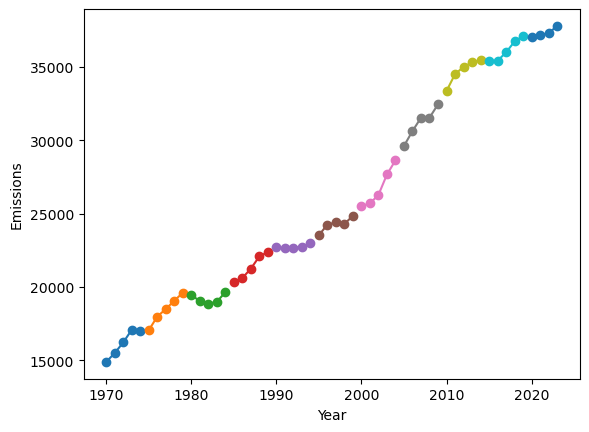

In [47]:
best_seg = complete_test.optimize_segments(min_segment=5, max_segment=15)['best']
for seg in best_seg['segments']:
    plt.plot(seg['years'], seg['emissions'], marker='o')
plt.xlabel("Year")
plt.ylabel("Emissions")
plt.show()

## Run enhanced analysis


Running Complete Enhanced Emissions Peak Test...
Optimizing segments using excluded data (48 points)
Forced method 'hybrid': 6 segments, score = 164590.4
Analyzing autocorrelation using interpolated data (54 points)
Autocorrelation analysis:
  Lag-1 autocorr: 0.295
  AR(1) φ: 0.295
  Innovation σ: 311.5
  Has significant autocorr: True
Using AR(1) noise generator with φ=0.295
Test data: 3 years, slope = -200.00 Mt/yr
Recent historical trend: 354.19 Mt/yr
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 5000
Results:
  P-value: 0.1178
  Significant at α=0.05: False
  Effect size: 1.19 standard deviations

FINAL INTERPRETATION:
Observed Slope: -200.00 Mt/year
Null Trend: 0.00 Mt/year
P Value: 0.1178
Strength: weak
Conclusion: Declining trend but not statistically significant
Effect Size: 1.19 standard deviations
Autocorr Adjustment: Yes
N Segments: 6

Generating comprehensive analysis plot...


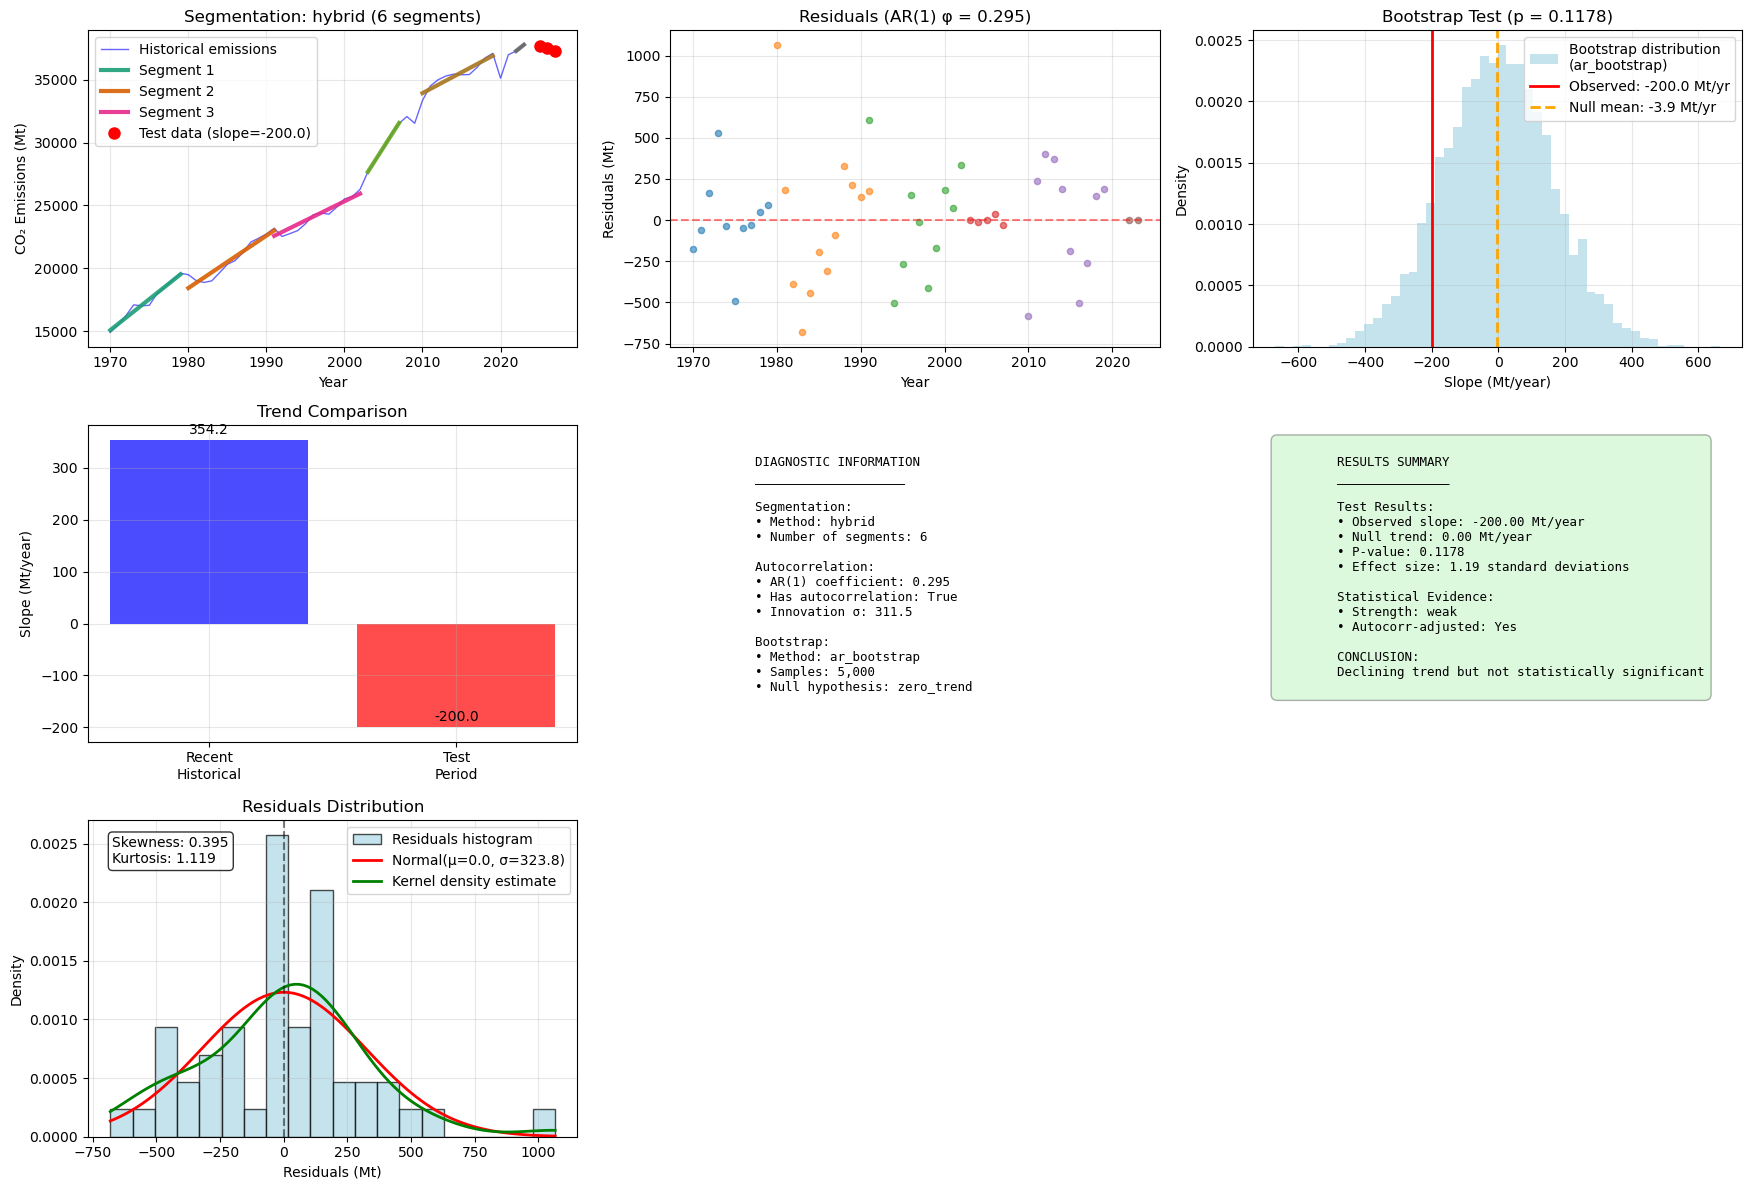

In [16]:
# Cell 4: Run the complete enhanced analysis

print("\nRunning Complete Enhanced Emissions Peak Test...")
print("=" * 60)

# select years of major events to consider
major_events = [1991, 2008, 2020]


# # Default behavior (test all methods, pick optimal)
# complete_test.optimize_segments(data_version = 'raw')

# # Use hybrid approach (dynamic within event periods)
complete_test.optimize_segments(force_method='hybrid', data_version = 'excluded', event_years=major_events) # data_version must be 'raw', 'excluded', or 'interpolated'

# Test all methods including events, but let algorithm pick best
# complete_test.optimize_segments(event_years=major_events, data_version = 'excluded')  # Tests all 4 methods


# # test why equal segments are favoured
# segments_info = complete_test.optimal_segments

# print("SEGMENTATION COMPARISON:")
# print("=" * 40)

# for method_result in segments_info['all_tested']:
#     method = method_result['method']
#     score = method_result['score']
#     n_segments = len(method_result['segments'])
    
#     if method == 'equal':
#         seg_len = method_result['segment_length']
#         print(f"Equal segments (length {seg_len}): {n_segments} segments, score = {score:.1f}")
#     else:
#         print(f"Dynamic segments: {n_segments} segments, score = {score:.1f}")

# print(f"\nBest method: {segments_info['best']['method']}")


complete_test.analyze_autocorrelation(data_version = 'interpolated') # Use interpolation where anomalous data removed (can also choose use_segmentation_data = True)
complete_test.create_noise_generator()
complete_test.set_test_data(test_data, recent_years_for_trend=5) # change years for trend - 5 years gives the shallowest trend

results = complete_test.run_complete_bootstrap_test(
    n_bootstrap=5000,
    null_hypothesis="zero_trend",  # Test for acceleration vs recent trend - can select "recent_trend" or "zero_trend" to test against null hypothesis of flat line
    bootstrap_method="ar_bootstrap"   # Bootstrap_method: "ar_bootstrap" (factors in autocorrelation), "block_bootstrap", or "white_noise" (residuals are independent over time)
)

# Cell 5: Display results and interpretation
print("\nFINAL INTERPRETATION:")
print("=" * 40)

interpretation = complete_test.interpret_results()
for key, value in interpretation.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

# Cell 6: Create comprehensive visualization
print("\nGenerating comprehensive analysis plot...")
fig = complete_test.plot_complete_analysis(figsize=(18, 12))
plt.show()


In [10]:
# Cell 7: Display detailed results
print("\nDETAILED BOOTSTRAP RESULTS:")
print("=" * 40)

r = complete_test.bootstrap_results
print(f"Test slope: {r['test_slope']:.2f} Mt/year")
print(f"Recent historical trend: {r['recent_historical_trend']:.2f} Mt/year")
print(f"Bootstrap samples: {r['n_bootstrap']:,}")
print(f"P-value (one-tailed): {r['p_value_one_tail']:.4f}")
print(f"Effect size: {r['effect_size']:.2f} standard deviations")
print(f"Significant at α=0.05: {r['significant_at_0_05']}")
print(f"Significant at α=0.01: {r['significant_at_0_01']}")




DETAILED BOOTSTRAP RESULTS:
Test slope: -200.00 Mt/year
Recent historical trend: 354.19 Mt/year
Bootstrap samples: 5,000
P-value (one-tailed): 0.1046
Effect size: 1.24 standard deviations
Significant at α=0.05: False
Significant at α=0.01: False


In [22]:
# Cell 8: Sensitivity analysis (optional) # NEEDS UPDATING
print("\nSENSITIVITY ANALYSIS:")
print("=" * 30)

# Test different methodological approaches
scenarios = [
    {"null": "zero_trend", "bootstrap": "white_noise", "name": "Naive"},
    {"null": "zero_trend", "bootstrap": "ar_bootstrap", "name": "Autocorr only"},
    {"null": "recent_trend", "bootstrap": "white_noise", "name": "Recent trend only"},
    {"null": "recent_trend", "bootstrap": "ar_bootstrap", "name": "Full enhanced"},
]

sensitivity_results = {}

for scenario in scenarios:
    print(f"\nTesting: {scenario['name']}")
    
    # Create new instance for each test
    test_instance = CompleteEnhancedEmissionsPeakTest()
    
    try:
        # Load same data
        test_instance.load_historical_data(
            'gcb_hist_co2.csv', 
            emissions_col='fossil_co2_emissions', 
            year_range=range(1970, 2024)
        )
        
        # Run analysis with different parameters
        test_instance.optimize_segments()
        test_instance.analyze_autocorrelation()
        test_instance.create_noise_generator()
        test_instance.set_test_data(test_data)
        
        results = test_instance.run_complete_bootstrap_test(
            n_bootstrap=2000,  # Smaller sample for speed
            null_hypothesis=scenario["null"],
            bootstrap_method=scenario["bootstrap"]
        )
        
        sensitivity_results[scenario["name"]] = {
            'p_value': results['p_value_one_tail'],
            'significant': results['significant_at_0_05'],
            'effect_size': results['effect_size']
        }
        
        print(f"  P-value: {results['p_value_one_tail']:.4f}")
        print(f"  Significant: {results['significant_at_0_05']}")
        print(f"  Effect size: {results['effect_size']:.2f}")
        
    except Exception as e:
        print(f"  Error: {e}")
        sensitivity_results[scenario["name"]] = None

# Cell 9: Summary comparison table
print(f"\n{'Method':<20} {'P-value':<10} {'Significant':<12} {'Effect Size':<12}")
print("-" * 60)

for name, result in sensitivity_results.items():
    if result:
        sig_str = "Yes" if result['significant'] else "No"
        print(f"{name:<20} {result['p_value']:<10.4f} {sig_str:<12} {result['effect_size']:<12.2f}")
    else:
        print(f"{name:<20} {'Error':<10} {'Error':<12} {'Error':<12}")

print("\nAnalysis complete! 🎉")

# Cell 10: Export results (optional)
print("\nEXPORTING RESULTS...")

# Save key results to CSV
results_df = pd.DataFrame({
    'metric': ['test_slope', 'recent_historical_trend', 'p_value', 'significant_05', 
               'effect_size', 'autocorr_phi', 'n_segments'],
    'value': [
        complete_test.bootstrap_results['test_slope'],
        complete_test.bootstrap_results['recent_historical_trend'], 
        complete_test.bootstrap_results['p_value_one_tail'],
        complete_test.bootstrap_results['significant_at_0_05'],
        complete_test.bootstrap_results['effect_size'],
        complete_test.autocorr_params['phi'],
        len(complete_test.optimal_segments['best']['segments'])
    ]
})

# results_df.to_csv('emissions_peak_test_results.csv', index=False)
# print("Results saved to: emissions_peak_test_results.csv")

# # Save the comprehensive plot
# fig.savefig('emissions_peak_analysis.png', dpi=300, bbox_inches='tight')
# print("Plot saved to: emissions_peak_analysis.png")


SENSITIVITY ANALYSIS:

Testing: Naive
Filtering data to year range: 1970-2023
Processed data: 1970-2023
Data points: 54
Emissions range: 14899 - 37792
Optimizing segment lengths...
Optimal: equal method, 11 segments
Analyzing autocorrelation...
Autocorrelation analysis:
  Lag-1 autocorr: -0.147
  AR(1) φ: -0.150
  Innovation σ: 266.7
  Has significant autocorr: True
Using AR(1) noise generator with φ=-0.150
Test data: 3 years, slope = -100.00 Mt/yr
Recent historical trend: 242.15 Mt/yr
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: white_noise
  Bootstrap samples: 2000
Results:
  P-value: 0.2995
  Significant at α=0.05: False
  Effect size: 0.53 standard deviations
  P-value: 0.2995
  Significant: False
  Effect size: 0.53

Testing: Autocorr only
Filtering data to year range: 1970-2023
Processed data: 1970-2023
Data points: 54
Emissions range: 14899 - 37792
Optimizing segment lengths...
Optimal: equal method, 11 segments
Analyzing autocorrelation.

Optimizing segments using raw data (54 points)
Optimal: equal method, 11 segments
Analyzing autocorrelation using raw data (54 points)
Autocorrelation analysis:
  Lag-1 autocorr: -0.147
  AR(1) φ: -0.150
  Innovation σ: 266.7
  Has significant autocorr: True
Using AR(1) noise generator with φ=-0.150
Test data: 3 years, slope = -200.00 Mt/yr
Recent historical trend: 354.19 Mt/yr
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 5000
Results:
  P-value: 0.0656
  Significant at α=0.05: False
  Effect size: 1.52 standard deviations

FINAL INTERPRETATION:
Observed Slope: -200.00 Mt/year
Null Trend: 0.00 Mt/year
P Value: 0.0656
Strength: weak
Conclusion: Declining trend but not statistically significant
Effect Size: 1.52 standard deviations
Autocorr Adjustment: Yes
N Segments: 11

Generating comprehensive analysis plot...


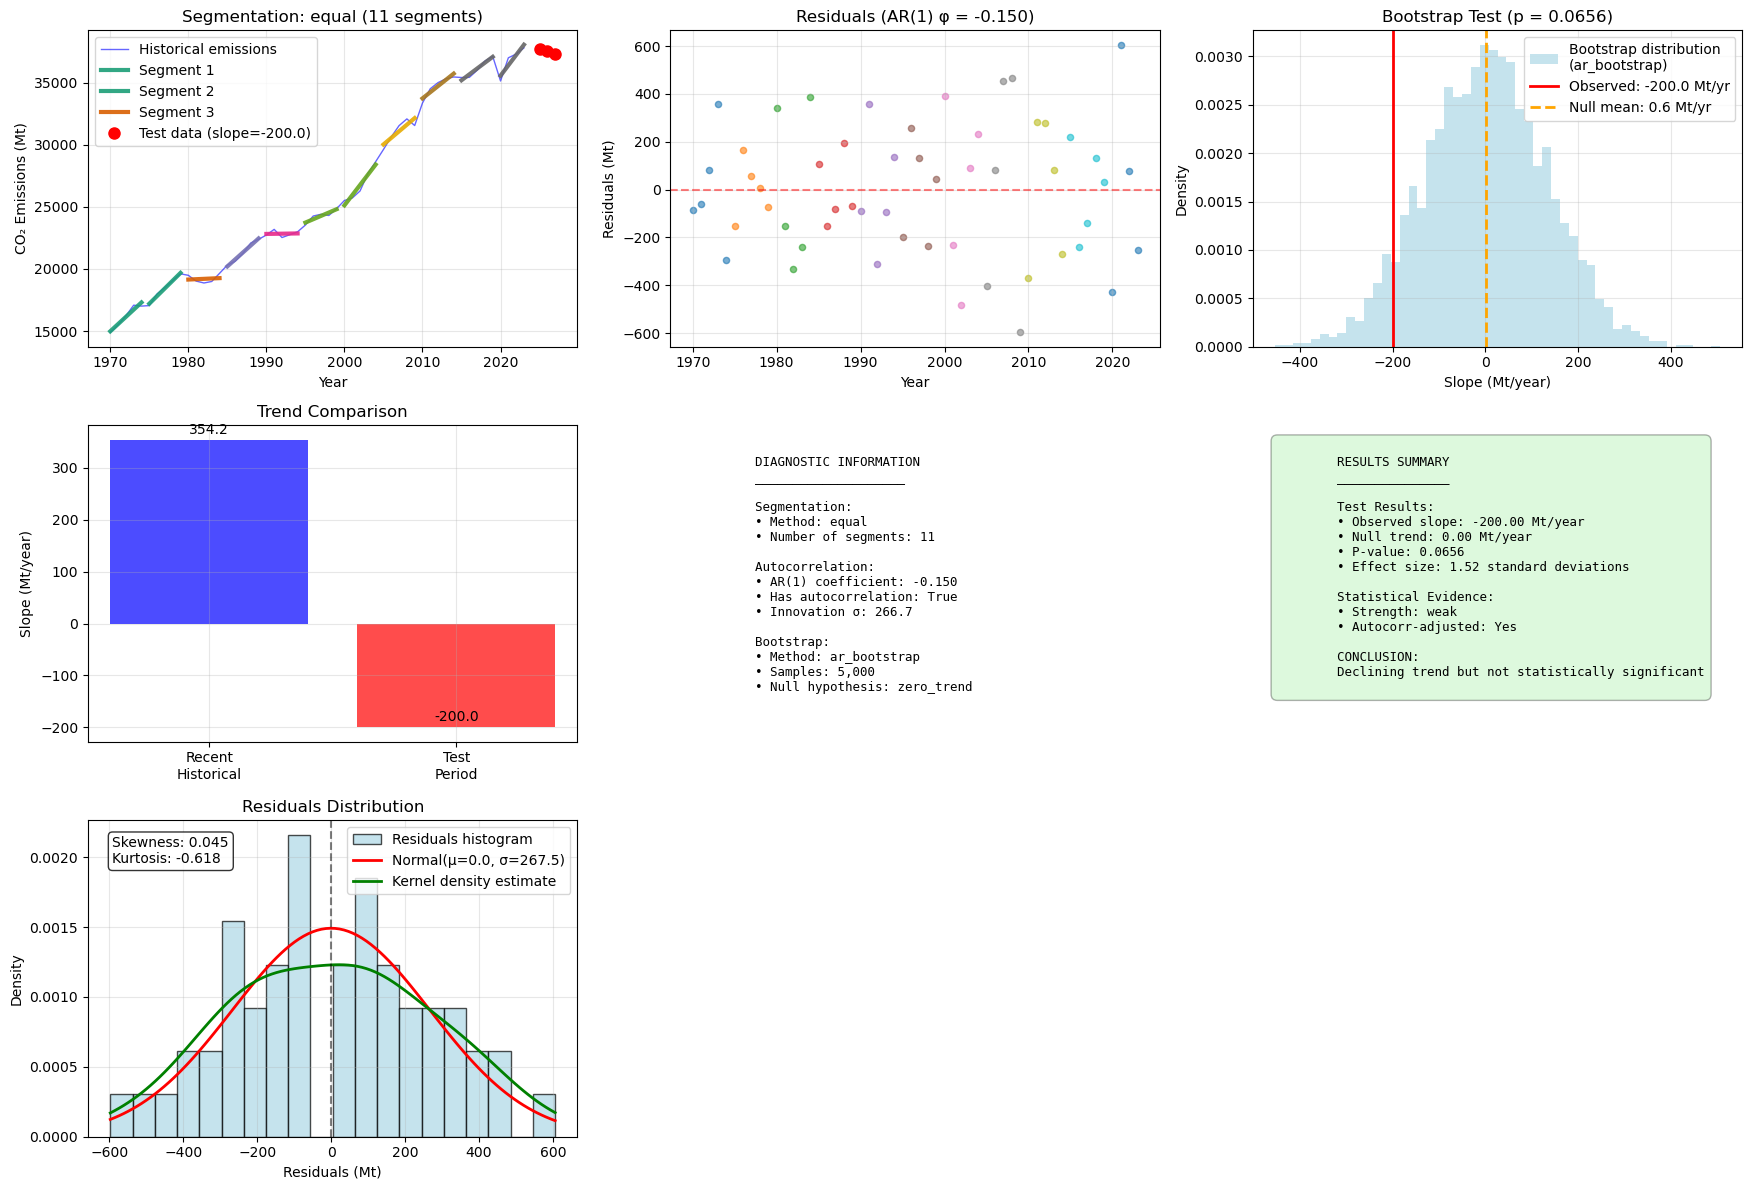

Optimizing segments using excluded data (48 points)
Optimal: equal method, 10 segments
Analyzing autocorrelation using excluded data (48 points)
Autocorrelation analysis:
  Lag-1 autocorr: -0.131
  AR(1) φ: -0.132
  Innovation σ: 211.2
  Has significant autocorr: True
Using AR(1) noise generator with φ=-0.132
Test data: 3 years, slope = -200.00 Mt/yr
Recent historical trend: 354.19 Mt/yr
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 5000
Results:
  P-value: 0.0292
  Significant at α=0.05: True
  Effect size: 1.88 standard deviations

FINAL INTERPRETATION:
Observed Slope: -200.00 Mt/year
Null Trend: 0.00 Mt/year
P Value: 0.0292
Strength: moderate
Conclusion: Moderate evidence that emissions have peaked
Effect Size: 1.88 standard deviations
Autocorr Adjustment: Yes
N Segments: 10

Generating comprehensive analysis plot...


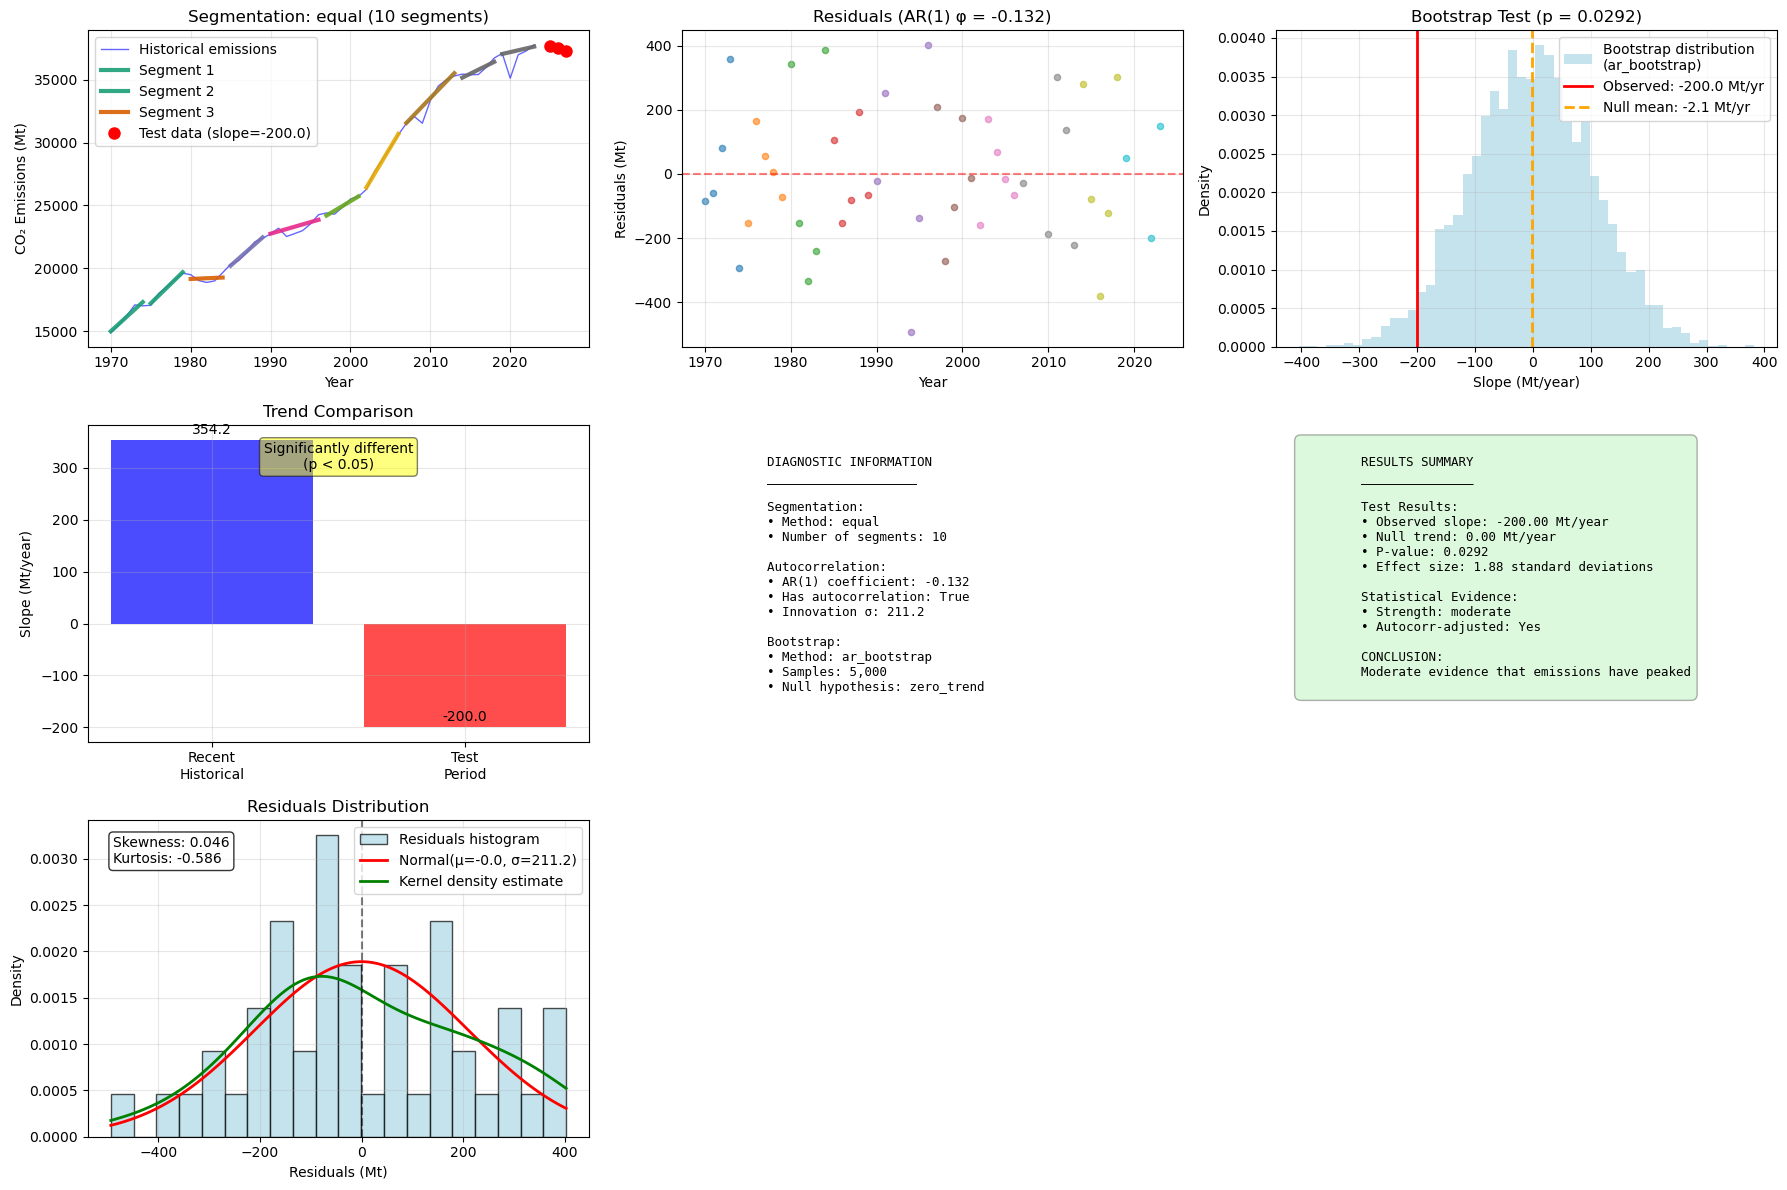

Optimizing segments using interpolated data (54 points)
Optimal: equal method, 11 segments
Analyzing autocorrelation using interpolated data (54 points)
Autocorrelation analysis:
  Lag-1 autocorr: -0.160
  AR(1) φ: -0.161
  Innovation σ: 212.2
  Has significant autocorr: True
Using AR(1) noise generator with φ=-0.161
Test data: 3 years, slope = -200.00 Mt/yr
Recent historical trend: 354.19 Mt/yr
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 5000
Results:
  P-value: 0.0276
  Significant at α=0.05: True
  Effect size: 1.91 standard deviations

FINAL INTERPRETATION:
Observed Slope: -200.00 Mt/year
Null Trend: 0.00 Mt/year
P Value: 0.0276
Strength: moderate
Conclusion: Moderate evidence that emissions have peaked
Effect Size: 1.91 standard deviations
Autocorr Adjustment: Yes
N Segments: 11

Generating comprehensive analysis plot...


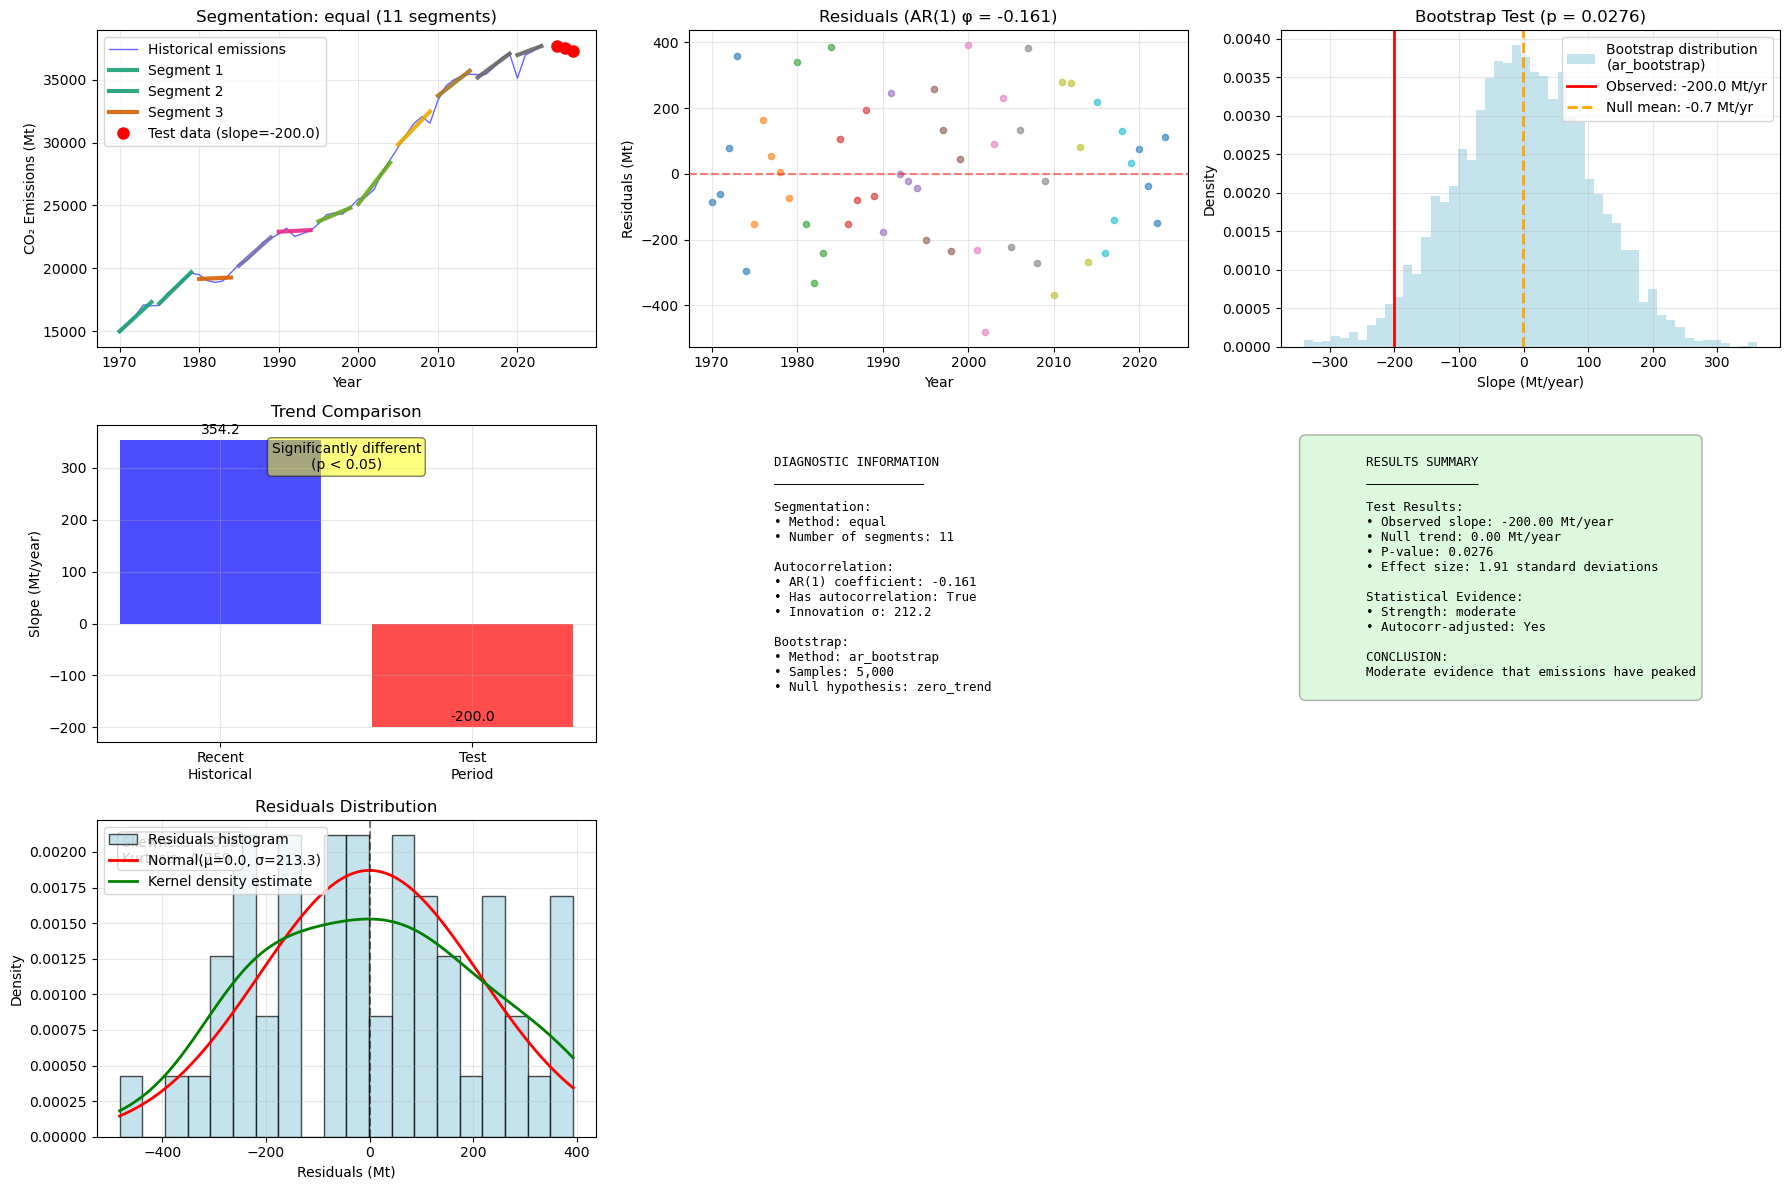

In [8]:
# Sensitivity analysis - using raw, excluded and interpolated data for segment creation and autocorrelation (and optimised segment creation)

for data_version in ['raw', 'excluded', 'interpolated']:
    complete_test.optimize_segments(data_version=data_version)
    complete_test.analyze_autocorrelation(data_version=data_version)
    complete_test.create_noise_generator()
    complete_test.set_test_data(test_data, recent_years_for_trend=5) # change years for trend - 5 years gives the shallowest trend
    
    results = complete_test.run_complete_bootstrap_test(
        n_bootstrap=5000,
        null_hypothesis="zero_trend",  # Test for acceleration vs recent trend - can select "recent_trend" or "zero_trend" to test against null hypothesis of flat line
        bootstrap_method="ar_bootstrap"   # Account for autocorrelation
    )
    
    # Cell 5: Display results and interpretation
    print("\nFINAL INTERPRETATION:")
    print("=" * 40)
    
    interpretation = complete_test.interpret_results()
    for key, value in interpretation.items():
        print(f"{key.replace('_', ' ').title()}: {value}")
    
    # Cell 6: Create comprehensive visualization
    print("\nGenerating comprehensive analysis plot...")
    fig = complete_test.plot_complete_analysis(figsize=(18, 12))
    plt.show()

    

# # Compare approaches options to consider
# complete_test.optimize_segments(data_version='raw')
# complete_test.analyze_autocorrelation(data_version='raw')
# # vs
# complete_test.optimize_segments(data_version='excluded') 
# complete_test.analyze_autocorrelation(data_version='interpolated')
# """